OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [1]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [2]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [3]:
from functions import *

In [4]:
import os, warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore")

In [5]:
# Set random integer (seed) - 891
from random import randrange
#seed = randrange(1000)
seed = 42
print("Seed value: ", seed)

Seed value:  42


#### Loading dataset

In [6]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
#  "Neighborhood",
category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'Neighborhood': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [7]:
path = "./dataset/cleaned/"
filename = "2016_Building_Energy_Prediction.csv"
dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type
data = pd.read_csv(dataset_path, dtype=category_types, sep=",")

In [8]:
data.shape

(3157, 37)

In [9]:
data.dtypes

OSEBuildingID                             int64
BuildingType                           category
PrimaryPropertyType                    category
ZipCode                                category
CouncilDistrictCode                    category
Neighborhood                           category
YearBuilt                                 int64
NumberofBuildings                       float64
NumberofFloors                            int64
PropertyGFATotal                          int64
PropertyGFAParking                        int64
PropertyGFABuilding(s)                    int64
LargestPropertyUseType                 category
LargestPropertyUseTypeGFA               float64
SecondLargestPropertyUseType           category
SecondLargestPropertyUseTypeGFA         float64
ThirdLargestPropertyUseType            category
ThirdLargestPropertyUseTypeGFA          float64
ENERGYSTARScore                         float64
SiteEnergyUse(kBtu)                     float64
SteamUse(kBtu)                          

In [10]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [11]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'Log-NumberofBuildings',
       'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFAParking',
       'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA',
       'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA', 'Log-SiteEnergyUse(kBtu)',
       'Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)',
       'Log-TotalGHGEmissions'],

In [12]:
features_for_prediction = ["YearBuilt", "BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "Log-NumberofFloors", "Log-PropertyGFATotal", "Log-PropertyGFABuilding(s)", "Log-PropertyGFAParking", "Log-LargestPropertyUseTypeGFA", "Log-SecondLargestPropertyUseTypeGFA", "Log-ThirdLargestPropertyUseTypeGFA"]

#features_for_prediction = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA",
   #                        "BuildingType","PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

variable_to_predict = "Log-Electricity(kBtu)"

features_for_prediction.append(variable_to_predict)
print(features_for_prediction)


['YearBuilt', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-PropertyGFAParking', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'Log-Electricity(kBtu)']


In [13]:
data = data[features_for_prediction]

data

,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-Electricity(kBtu)
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,central,Multifamily Housing,1.386294,9.939819,9.939819,0.000000,9.777301,0.000000,0.000000,13.612540
1,1928,NonResidential,Warehouse,greater duwamish,Non-Refrigerated Warehouse,1.098612,10.164158,10.164158,0.000000,9.557541,9.076352,8.026497,14.012813
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,1.386294,10.131459,10.131459,0.000000,10.131459,0.000000,0.000000,12.624928
3,1971,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,Multifamily Housing,2.772589,11.210455,11.210455,0.000000,11.288694,0.000000,0.000000,14.583001
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,1.386294,10.501884,10.287184,8.858084,10.132772,8.343078,0.000000,13.397146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,2001,NonResidential,Mixed Use Property,lake union,Multifamily Housing,1.386294,10.641321,10.392129,9.129889,9.566195,9.555985,9.177920,14.707138
3153,1907,Multifamily LR (1-4),Low-Rise Multifamily,lake union,Multifamily Housing,1.609438,10.509469,10.509469,0.000000,10.509469,0.000000,0.000000,13.156997
3154,2001,NonResidential,Small- and Mid-Sized Office,lake union,Office,1.791759,10.426469,10.230306,8.701346,9.674640,9.078294,7.313887,14.071242
3155,1911,NonResidential,Retail Store,lake union,Retail Store,1.098612,9.929009,9.929009,0.000000,9.225820,8.987322,0.000000,12.487428


## I) Feature Engineering : preparing the vectors and matrices


#### 1) Separating training data and target vector

In [14]:
# we create the data matrix / we only take the features
X = data[data.columns[:-1]]

# we create the target vector
y = data[variable_to_predict].values # numpy array not a DataFrame anymore

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

Shape of X : (3157, 12)
Shape of y : (3157,)


In [15]:
X

,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,central,Multifamily Housing,1.386294,9.939819,9.939819,0.000000,9.777301,0.000000,0.000000
1,1928,NonResidential,Warehouse,greater duwamish,Non-Refrigerated Warehouse,1.098612,10.164158,10.164158,0.000000,9.557541,9.076352,8.026497
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,1.386294,10.131459,10.131459,0.000000,10.131459,0.000000,0.000000
3,1971,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,Multifamily Housing,2.772589,11.210455,11.210455,0.000000,11.288694,0.000000,0.000000
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,1.386294,10.501884,10.287184,8.858084,10.132772,8.343078,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3152,2001,NonResidential,Mixed Use Property,lake union,Multifamily Housing,1.386294,10.641321,10.392129,9.129889,9.566195,9.555985,9.177920
3153,1907,Multifamily LR (1-4),Low-Rise Multifamily,lake union,Multifamily Housing,1.609438,10.509469,10.509469,0.000000,10.509469,0.000000,0.000000
3154,2001,NonResidential,Small- and Mid-Sized Office,lake union,Office,1.791759,10.426469,10.230306,8.701346,9.674640,9.078294,7.313887
3155,1911,NonResidential,Retail Store,lake union,Retail Store,1.098612,9.929009,9.929009,0.000000,9.225820,8.987322,0.000000


#### 2) Separation train and test dataset


In [16]:
print("We have to separate the train / test sets before normalising the dataset.")

We have to separate the train / test sets before normalising the dataset.


In [17]:
# We create a training set and a test set (the test set contains 30% of the dataset)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,  random_state=seed)

In [18]:
X_train.shape

(2209, 12)

In [19]:
X_test.shape

(948, 12)

#### 3) Normalization

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [21]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [22]:
X.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(include='number').columns.drop("YearBuilt") ###
#numerical_columns = X.select_dtypes(include='number').columns
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (4,)
Shape of numerical variables : (7,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [23]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 7 numerical features to standardize.

Index(['Log-NumberofFloors', 'Log-PropertyGFATotal',
       'Log-PropertyGFABuilding(s)', 'Log-PropertyGFAParking',
       'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [24]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scale = StandardScaler().fit(X_train[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = std_scale.transform(X_train[numerical_columns])
X_test_std[numerical_columns] = std_scale.transform(X_test[numerical_columns])

print("Before")
display(X_train)
print("After")
display(X_train_std)

Before


,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
748,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,1.386294,11.708788,11.708788,0.000000,11.708788,0.000000,0.000000
2581,1977,Multifamily LR (1-4),Low-Rise Multifamily,lake union,Multifamily Housing,1.386294,9.922506,9.922506,0.000000,9.922506,6.645091,0.000000
662,1966,Multifamily LR (1-4),Low-Rise Multifamily,southeast,Multifamily Housing,1.098612,9.966509,9.966509,0.000000,9.966509,0.000000,0.000000
480,1957,NonResidential,Worship Facility,delridge,Worship Facility,1.098612,10.095140,10.095140,0.000000,10.095140,0.000000,0.000000
803,1908,Multifamily MR (5-9),Mid-Rise Multifamily,downtown,Multifamily Housing,2.079442,11.981935,11.981935,0.000000,11.753367,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3092,1985,NonResidential,Large Office,lake union,Office,1.791759,11.833116,11.317336,10.924228,11.261858,10.924228,8.398184
1095,2013,Multifamily MR (5-9),Mid-Rise Multifamily,northeast,Multifamily Housing,1.945910,11.345429,11.345429,0.000000,10.569264,9.888425,0.000000
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,northwest,Multifamily Housing,1.945910,12.585799,12.585799,0.000000,12.328140,10.852516,10.278390
1294,1947,Multifamily LR (1-4),Low-Rise Multifamily,northwest,Multifamily Housing,1.386294,10.123466,10.123466,0.000000,10.123466,0.000000,0.000000


After


,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
748,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing,-0.287845,0.884483,0.993927,-0.431261,1.102711,-0.957452,-0.457763
2581,1977,Multifamily LR (1-4),Low-Rise Multifamily,lake union,Multifamily Housing,-0.287845,-1.160191,-1.146519,-0.431261,-0.984524,0.416765,-0.457763
662,1966,Multifamily LR (1-4),Low-Rise Multifamily,southeast,Multifamily Housing,-0.779034,-1.109822,-1.093790,-0.431261,-0.933106,-0.957452,-0.457763
480,1957,NonResidential,Worship Facility,delridge,Worship Facility,-0.779034,-0.962584,-0.939656,-0.431261,-0.782803,-0.957452,-0.457763
803,1908,Multifamily MR (5-9),Mid-Rise Multifamily,downtown,Multifamily Housing,0.895635,1.197141,1.321230,-0.431261,1.154800,-0.957452,-0.457763
...,...,...,...,...,...,...,...,...,...,...,...,...
3092,1985,NonResidential,Large Office,lake union,Office,0.404446,1.026795,0.524863,2.460933,0.580482,1.301698,2.056650
1095,2013,Multifamily MR (5-9),Mid-Rise Multifamily,northeast,Multifamily Housing,0.667643,0.468563,0.558526,-0.431261,-0.228800,1.087492,-0.457763
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,northwest,Multifamily Housing,0.667643,1.888357,2.044821,-0.431261,1.826411,1.286868,2.619583
1294,1947,Multifamily LR (1-4),Low-Rise Multifamily,northwest,Multifamily Housing,-0.287845,-0.930161,-0.905714,-0.431261,-0.749706,-0.957452,-0.457763


We can check that the numerical variables have a Standard Normal distribution.


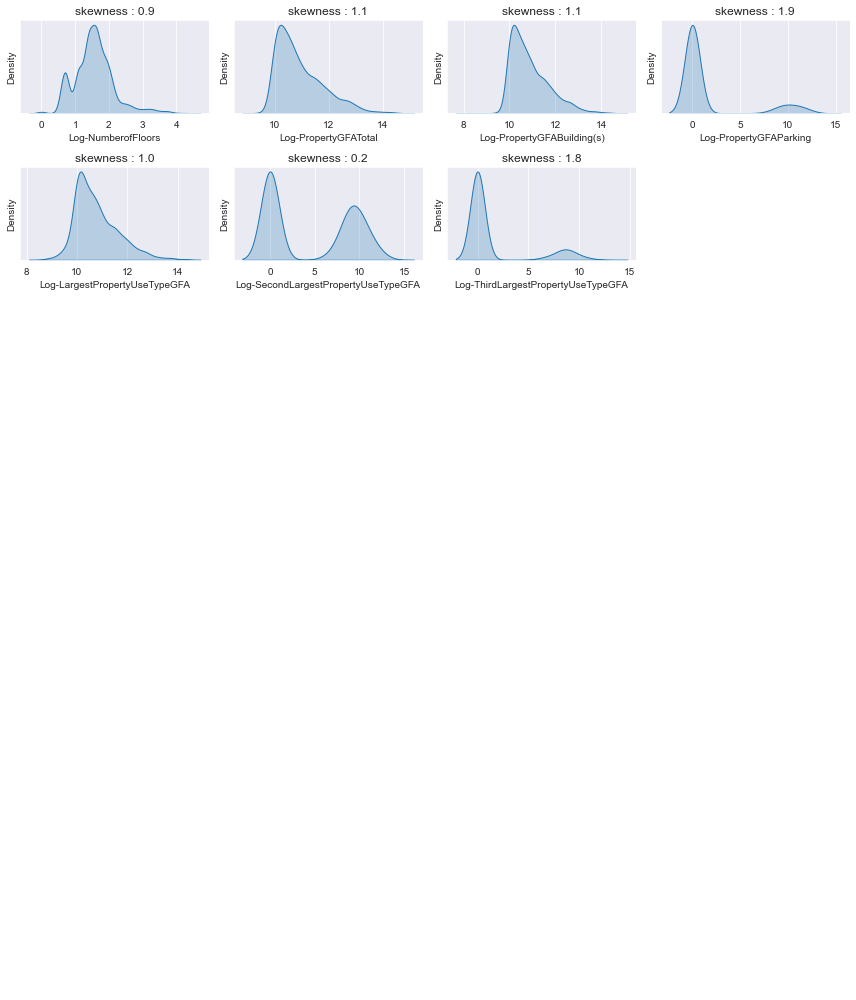

In [25]:
print("We can check that the numerical variables have a Standard Normal distribution.")
densite(X_train[numerical_columns])

##### 2) Feature Encoding : One Hot Encoder

In [26]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 4 categorical features to encode.

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType'],
      dtype='object')


In [27]:
X.dtypes # we check that we have categories

YearBuilt                                 int64
BuildingType                           category
PrimaryPropertyType                    category
Neighborhood                           category
LargestPropertyUseType                 category
Log-NumberofFloors                      float64
Log-PropertyGFATotal                    float64
Log-PropertyGFABuilding(s)              float64
Log-PropertyGFAParking                  float64
Log-LargestPropertyUseTypeGFA           float64
Log-SecondLargestPropertyUseTypeGFA     float64
Log-ThirdLargestPropertyUseTypeGFA      float64
dtype: object

In [28]:
X[categorical_columns].nunique()

BuildingType               8
PrimaryPropertyType       23
Neighborhood              13
LargestPropertyUseType    55
dtype: int64

In [29]:
X_train_std[categorical_columns]

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType
748,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,Multifamily Housing
2581,Multifamily LR (1-4),Low-Rise Multifamily,lake union,Multifamily Housing
662,Multifamily LR (1-4),Low-Rise Multifamily,southeast,Multifamily Housing
480,NonResidential,Worship Facility,delridge,Worship Facility
803,Multifamily MR (5-9),Mid-Rise Multifamily,downtown,Multifamily Housing
...,...,...,...,...
3092,NonResidential,Large Office,lake union,Office
1095,Multifamily MR (5-9),Mid-Rise Multifamily,northeast,Multifamily Housing
1130,Multifamily MR (5-9),Mid-Rise Multifamily,northwest,Multifamily Housing
1294,Multifamily LR (1-4),Low-Rise Multifamily,northwest,Multifamily Housing


##### Encoding the categorical features of the train set


In [30]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([X[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 99 columns to encodes the categorical features.


In [31]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(X_train_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(X_train_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
X_train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=X_train_std.index)
display(X_train_encoded.sort_index())

We have indeed : 94 labels after encoding the categorical variables.


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3149,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3151,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# 5) Concatenate the two dataframes for the training set

print("We need to add YearBuilt to the list of features.")
numerical_columns.tolist()
features_to_merge = numerical_columns.tolist().copy()
features_to_merge.append("YearBuilt") ###
print(features_to_merge, end="\n\n")

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_train_std_encoded = pd.merge(X_train_std[features_to_merge].sort_index(), X_train_encoded.sort_index(), left_index=True, right_index=True)
display(X_train_std_encoded.sort_index())

We need to add YearBuilt to the list of features.
['Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-PropertyGFAParking', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
1,-0.779034,-0.883583,-0.856954,-0.431261,-1.410978,0.919554,1.945367,1928,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287845,-0.921011,-0.896136,-0.431261,-0.740365,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.079115,0.314064,0.396790,-0.431261,0.611839,-0.957452,-0.457763,1971,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.287845,-0.497003,-0.709536,1.913920,-0.738832,0.767912,-0.457763,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093150,-0.418702,-0.370298,-0.431261,-0.227600,-0.957452,-0.457763,1996,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,-0.287845,-0.681344,-0.645243,-0.431261,-0.495710,-0.957452,-0.457763,1920,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3149,-0.287845,-1.038624,-1.019258,-0.431261,-0.860427,-0.957452,-0.457763,1946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3151,-0.779034,-0.579940,-0.539089,-0.431261,-1.082719,1.011777,1.719798,1927,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.404446,-0.583328,-0.777691,1.872424,-1.274149,0.919955,1.732012,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding the categorical features of the test set

In [33]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(X_test_std[categorical_columns])

print("ASK JEREMY for this method below ???")
# 5.2) we recreate a dataframe with the column names and the numpy array
X_test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=X_test_std.index)
display(X_test_encoded.sort_index())

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_test_std_encoded = pd.merge(X_test_std[features_to_merge].sort_index(), X_test_encoded.sort_index(), left_index=True, right_index=True)
display(X_test_std_encoded.sort_index())

ASK JEREMY for this method below ???


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,-0.287845,-1.140373,-1.125772,-0.431261,-1.154193,-0.957452,-0.457763,1978,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287845,0.875660,0.984690,-0.431261,0.854504,1.037213,-0.457763,1977,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.779034,-0.180711,-0.828488,2.208418,-0.547035,0.841658,-0.457763,1991,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.093150,1.181887,1.305261,-0.431261,0.009116,1.102696,2.030004,2010,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-1.471325,-0.694017,-0.658509,-0.431261,-0.594093,0.655805,-0.457763,1980,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,0.093150,-0.395407,-0.345912,-0.431261,-0.203820,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.404446,-0.074642,-0.010123,-0.431261,-0.034118,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,-0.287845,-0.337396,-0.583784,1.985881,-1.400865,1.018743,2.290103,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.093150,-0.488322,-0.443179,-0.431261,-0.298669,-0.957452,-0.457763,1907,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Save
#X_train_std_encoded.to_csv("dataset/cleaned/electricity/X_train.csv", index=False)
#X_test_std_encoded.to_csv("dataset/cleaned/electricity/X_test.csv", index=False)
#y_train.to_csv("dataset/cleaned/electricity/y_train.csv", index=False)
#y_test.to_csv("dataset/cleaned/electricity/y_test.csv", index=False)

## II) Modelisation

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [36]:
print("We can start now the modelling to predict the feature wanted.")

display(X_train_std_encoded)
display(X_test_std_encoded)
print(y_train.shape, y_test.shape)

We can start now the modelling to predict the feature wanted.


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
1,-0.779034,-0.883583,-0.856954,-0.431261,-1.410978,0.919554,1.945367,1928,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287845,-0.921011,-0.896136,-0.431261,-0.740365,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.079115,0.314064,0.396790,-0.431261,0.611839,-0.957452,-0.457763,1971,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.287845,-0.497003,-0.709536,1.913920,-0.738832,0.767912,-0.457763,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093150,-0.418702,-0.370298,-0.431261,-0.227600,-0.957452,-0.457763,1996,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,-0.287845,-0.681344,-0.645243,-0.431261,-0.495710,-0.957452,-0.457763,1920,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3149,-0.287845,-1.038624,-1.019258,-0.431261,-0.860427,-0.957452,-0.457763,1946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3151,-0.779034,-0.579940,-0.539089,-0.431261,-1.082719,1.011777,1.719798,1927,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.404446,-0.583328,-0.777691,1.872424,-1.274149,0.919955,1.732012,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,-0.287845,-1.140373,-1.125772,-0.431261,-1.154193,-0.957452,-0.457763,1978,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287845,0.875660,0.984690,-0.431261,0.854504,1.037213,-0.457763,1977,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.779034,-0.180711,-0.828488,2.208418,-0.547035,0.841658,-0.457763,1991,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.093150,1.181887,1.305261,-0.431261,0.009116,1.102696,2.030004,2010,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-1.471325,-0.694017,-0.658509,-0.431261,-0.594093,0.655805,-0.457763,1980,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,0.093150,-0.395407,-0.345912,-0.431261,-0.203820,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.404446,-0.074642,-0.010123,-0.431261,-0.034118,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,-0.287845,-0.337396,-0.583784,1.985881,-1.400865,1.018743,2.290103,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.093150,-0.488322,-0.443179,-0.431261,-0.298669,-0.957452,-0.457763,1907,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2209,) (948,)


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [38]:
print("We rename X_train_std_encoded to X_train, the same for X_test.")
X_train = X_train_std_encoded.copy()
X_test = X_test_std_encoded.copy()

X_train
X_test

We rename X_train_std_encoded to X_train, the same for X_test.


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-PropertyGFAParking,Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,-0.287845,-1.140373,-1.125772,-0.431261,-1.154193,-0.957452,-0.457763,1978,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287845,0.875660,0.984690,-0.431261,0.854504,1.037213,-0.457763,1977,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.779034,-0.180711,-0.828488,2.208418,-0.547035,0.841658,-0.457763,1991,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.093150,1.181887,1.305261,-0.431261,0.009116,1.102696,2.030004,2010,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-1.471325,-0.694017,-0.658509,-0.431261,-0.594093,0.655805,-0.457763,1980,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,0.093150,-0.395407,-0.345912,-0.431261,-0.203820,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.404446,-0.074642,-0.010123,-0.431261,-0.034118,-0.957452,-0.457763,1925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,-0.287845,-0.337396,-0.583784,1.985881,-1.400865,1.018743,2.290103,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.093150,-0.488322,-0.443179,-0.431261,-0.298669,-0.957452,-0.457763,1907,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1) Linear modelling : Linear Regression / Ridge Regression / Lasso / Elastic Net


In [39]:
X_train.shape

(2209, 102)

In [40]:
X_test.shape

(948, 102)

#### 1) Dummy Regression : baseline

In [41]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

pd.set_option('display.float_format', lambda x: '%.5f' % x)

global results
results = pd.DataFrame({})

def evaluate_regression(model_name, results, y_test, y_pred):
    print("Prediction for : ", variable_to_predict)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    #print("RMSE : {:.2f}".format(rmse))
    #print("MAE : {:.2f}".format(mae))
    #print("MSE : {:.2f}".format(mse))
    #print("R² : {:.2f}".format(r2))
    results = pd.concat([results, pd.DataFrame({"Model" : [model_name],
                               "RMSE" : [rmse],
                                "MSE": [mse],
                                "MAE" : [mae],
                                "Median Absolute Error": [median_ae],
                               "R² = 1 - RSE" : [r2]})])
    display(results)

    # 2) graph
    plt.title("Scatter plot of the predicted values as a function of the true values.")
    plt.legend("If the prediction was good, we would see a line.")
    plt.figure(0)
    plt.scatter(y_test, y_pred, color='coral')

    plt.title("Distribution of the prediction errors")
    err_hist = np.abs(y_test - y_pred)
    plt.figure(1)
    plt.hist(err_hist, bins=50, color='steelblue')

    return  results


In [42]:
def display_prediction(y_test, y_pred):
    #plt.scatter(y_test, y_pred, color='coral')

    sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
    for (yt, yp) in zip(list(y_test), list(y_pred)):
        if (yt, yp) in sizes:
            sizes[(yt, yp)] += 1
        else:
            sizes[(yt, yp)] = 1

    keys = sizes.keys()
    plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)


Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315


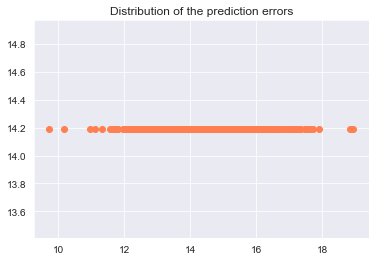

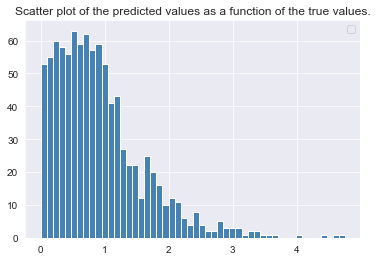

In [43]:
from sklearn import dummy

# 0) We create a dummy regressor model that always predicts the mean value of the feature to predict
dum = dummy.DummyRegressor(strategy='mean')

# 1) Training Dummy Regression
dum.fit(X_train, y_train)

# 2) Prediction on the testing set
y_pred_dum = dum.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Dummy Regressor", results, y_test, y_pred_dum)

#### 2) baseline : Linear Regression

R2 : -0.044316250396176926
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432


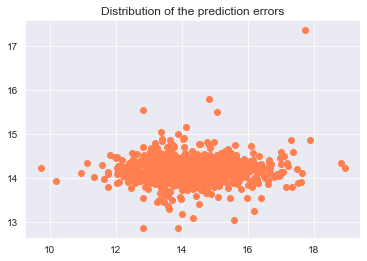

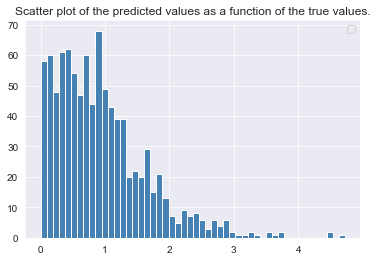

In [44]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

prediction_score = lr.score(X_test, y_test)
print('R2 : {}'.format(prediction_score))

results = evaluate_regression("Linear Regression", results, y_test, y_pred_lr)

In [45]:
baseline_error = mean_squared_error(y_test, y_pred_dum)
print("Baseline error = MSE from Dummy Regressor :", baseline_error)

Baseline error = MSE from Dummy Regressor : 1.3418646412284088


#### 2) Linear Model : Ridge

In [46]:
# Setting evaluation metric for regression
scoring = 'r2'

##### 2.1) Trying Ridge Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [47]:
a, b = -3, 2
n_alphas = 1000 # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((y_pred_ridge - y_test) ** 2))
    #print("HERE :", np.mean(( - y_test) ** 2), "MSE :", mean_squared_error(y_test, ridge.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for Ridge Regression : 1.3634404978072392
Best alpha for that minimal MSE :  100.0


(7.0794578438413736e-09,
 1.4125375446227728e+105,
 1.339112119265043,
 1.3996676024590897)

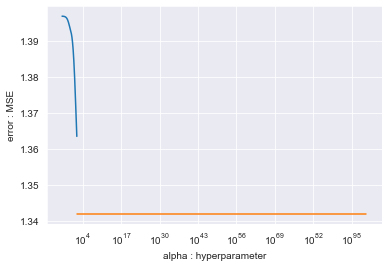

In [48]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [10**a, 10**b], [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(0.0005623413251903491,
 177.82794100389228,
 -3.3490326065096605,
 3.660464654632565)

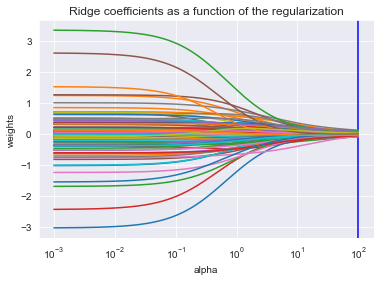

In [49]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  100.0
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928


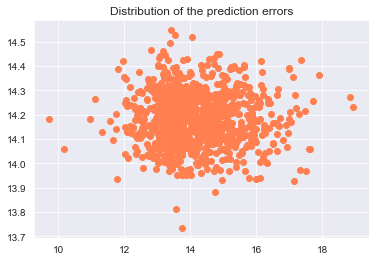

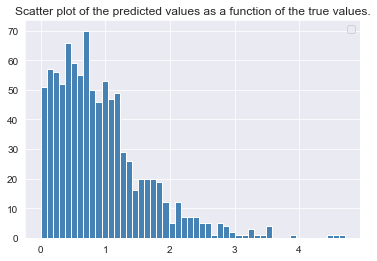

In [50]:
print("Getting y_pred for the best alpha : ", min_alpha)
ridge.set_params(alpha=min_alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Ridge manually", results, y_test, y_pred_ridge)

##### 2.2) Optimization of hyperparameters

In [51]:
# define the model/ estimator
model = linear_model.Ridge()
params = {"alpha": np.logspace(a, b, n_alphas)} # alpha > 0
scoring = "neg_mean_squared_error"

# define the grid search
Ridge_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Ridge_reg.fit(X_train.values, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e+100, 7.97814457e+099, 6.36507908e+099, 5.07815211e+099,
       4.05142317e+099, 3.23228398e+099, 2.57876289e+099, 2.05737431e+099,
       1.64140297e+099, 1.30953502e+099, 1.04476597e+099, 8.33529397e+098,
       6.65001803e+098, 5.30548053e+098, 4.23278907e+098, 3.37698031e+098,
       2.69420371e+098, 2.149...
       7.30909933e+003, 5.83130511e+003, 4.65229952e+003, 3.71167182e+003,
       2.96122544e+003, 2.36250847e+003, 1.88484341e+003, 1.50375532e+003,
       1.19971774e+003, 9.57152154e+002, 7.63629826e+002, 6.09234915e+002,
       4.86056423e+002, 3.87782841e+002, 3.09378757e+002, 2.46826845e+002,
       1.96922026e+002, 1.57107239e+002, 1.25342427e+002, 1.00000000e+002])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Best estimator : Ridge(alpha=1318621.4013947486)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423


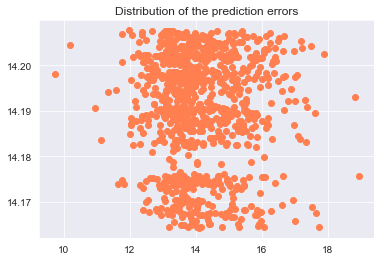

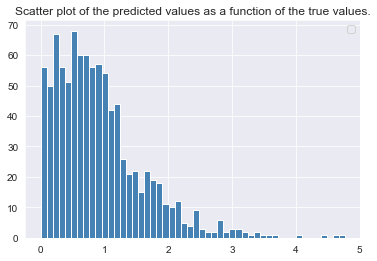

In [52]:
# best estimator
print("Best estimator :", Ridge_reg.best_estimator_)

# best model
best_model = Ridge_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_ridge = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Ridge GridSearchCV", results, y_test, y_pred_ridge)

In [53]:
print("QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? ")

QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? 


#### 3) Linear Model : LASSO

##### 3.1) Trying LASSO Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [54]:
n_alphas = 500  # hyperparametre alpha
a, b = -5, -2
alphas = np.logspace(a, b, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred_lasso - y_test) ** 2))
    #print("HERE :", np.mean((lasso.predict(X_test) - y_test) ** 2), "MSE :", mean_squared_error(y_test, lasso.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for LASSO Regression : 1.3470878448394783
Best alpha for that minimal MSE :  0.01


(5.623413251903491e-06,
 1.7782794100389228,
 1.339132624127292,
 1.3992370003518613)

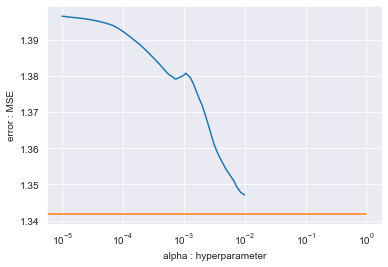

In [55]:
# recupere l'erreur min
print("Minimum Mean Squared Error for LASSO Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(7.079457843841373e-06,
 0.01412537544622754,
 -3.5050821601178286,
 3.66163773673552)

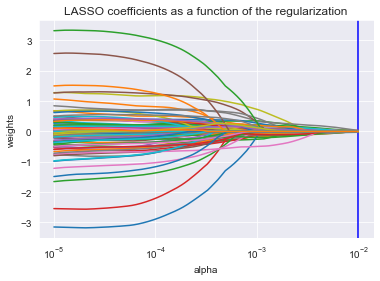

In [56]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  0.01
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705


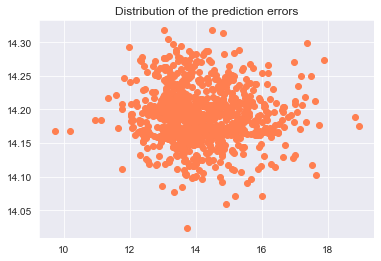

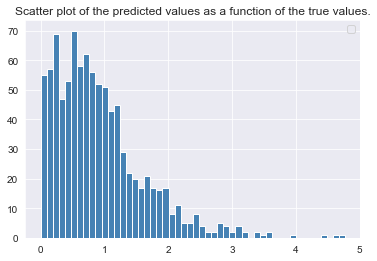

In [57]:
print("Getting y_pred for the best alpha : ", min_alpha)
lasso.set_params(alpha=min_alpha)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# 3) Evaluate
results = evaluate_regression("LASSO manually", results, y_test, y_pred_lasso)

In [58]:
y_pred_lasso

array([14.20221766, 14.19970228, 14.28753   , 14.2076355 , 14.22111359,
       14.17213652, 14.2259116 , 14.24109529, 14.20672889, 14.13940753,
       14.12308305, 14.16423273, 14.12509353, 14.17427187, 14.1637092 ,
       14.13306895, 14.19564343, 14.18252215, 14.20519873, 14.16300737,
       14.17498071, 14.12134902, 14.18168867, 14.21367938, 14.21015377,
       14.20129045, 14.28907143, 14.21298599, 14.29268904, 14.20397902,
       14.2276651 , 14.19215683, 14.18978081, 14.17122246, 14.1711926 ,
       14.18140719, 14.20597044, 14.1623726 , 14.1476647 , 14.25390749,
       14.1249064 , 14.22379178, 14.21193532, 14.14729881, 14.18532623,
       14.16445481, 14.19433872, 14.17191814, 14.17761904, 14.18366275,
       14.17683193, 14.16790577, 14.19199028, 14.18477678, 14.19491013,
       14.22061192, 14.23540538, 14.16302234, 14.16345081, 14.13016113,
       14.20192646, 14.15214705, 14.1826802 , 14.1721659 , 14.17346079,
       14.15708538, 14.11780411, 14.23961104, 14.27136281, 14.27

##### 3.2) Optimization of hyperparameters

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best estimator : Lasso(alpha=0.03040065094301666)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705
0,LASSO GridSearchCV,1.15936,1.34411,0.91563,0.77591,-0.00483


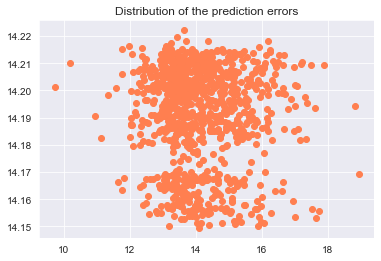

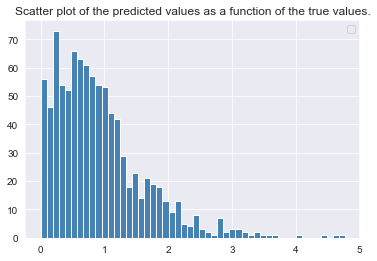

In [59]:
n_alphas = 1000
params = {"alpha": np.logspace(a, b, n_alphas)}

# define the model/ estimator
model = linear_model.Lasso()

# define the grid search
Lasso_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Lasso_reg.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", Lasso_reg.best_estimator_)

# best model
best_model = Lasso_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_lasso = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("LASSO GridSearchCV", results, y_test, y_pred_lasso)

In [60]:
y_pred_lasso
print("ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????")

ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????


#### 4) Linear Model : Elastic Net

##### 4.1) Trying Elastic Net Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameters alpha and l1_ratio

In [61]:
n = 100
l1_ratio = np.random.uniform(0, 1, size=(1, 100))
l1_ratio

l = [i / n for i in range(n)]
l = np.arange(0, 1, 10**-2)

l1_ratio = np.arange(start=0, stop=1, step= 1/n)
l1_ratio

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

min_index = np.argmin(alphas)
min_alpha = alphas[min_index]
min_alpha

##### 4.2) Optimization of hyperparameters

In [62]:
scoring

'neg_mean_squared_error'

R2 : -1.3418646412284088 RMSE : 1.1583888126308923 Best params : {'l1_ratio': 0.9, 'alpha': 184.20699693267164}
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705
0,LASSO GridSearchCV,1.15936,1.34411,0.91563,0.77591,-0.00483
0,Elastic Net 1,1.15839,1.34186,0.91528,0.77266,-0.00315


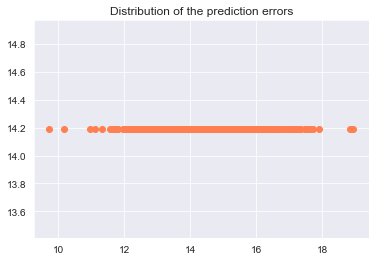

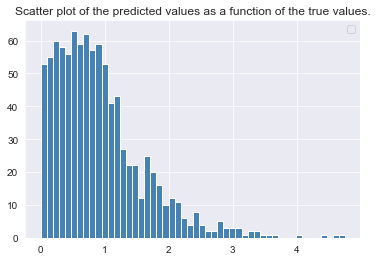

In [63]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold

regressor = linear_model.ElasticNet()

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=10, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

a, b , n_alphas = -3, 3, 50
param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]



# Intenciation of RandomizedSearchCV object
randomsearch = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_elastic, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=cv_inner, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
    n_iter=10, # number of combinations of hyper-parameters to try
)


# Call the RanddomizedSearch with Cross Validation using the chosen regressor
randomsearch.fit(X_train, y_train)
# Results
y_pred_elastic = randomsearch.predict(X_test)
R2_score = randomsearch.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", randomsearch.best_params_)
results = evaluate_regression("Elastic Net 1", results, y_test, y_pred_elastic)

R2 : -1.3440713585106046 RMSE : 1.1593409155682397 Best params : {'l1_ratio': 0.05, 'alpha': 0.655128556859551}
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705
0,LASSO GridSearchCV,1.15936,1.34411,0.91563,0.77591,-0.00483
0,Elastic Net 1,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Elastic Net 2,1.15934,1.34407,0.91559,0.77595,-0.00480


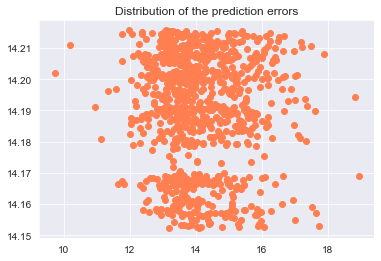

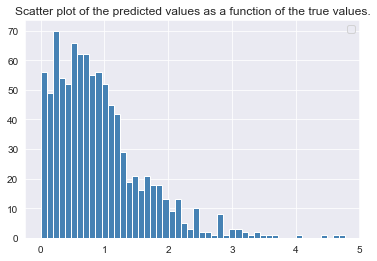

In [64]:
rs_cv= RandomizedSearchCV(estimator=regressor,
                          param_distributions=param_grid_elastic,
                          n_iter = 100,
                          scoring=scoring,
                          cv=5,
                          verbose=0,
                          refit=True,
                          n_jobs=-1,
                          return_train_score=True)
rs_cv.fit(X_train, y_train)

# Results
y_pred_elastic = rs_cv.predict(X_test)
R2_score = rs_cv.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", rs_cv.best_params_)
#print("Train score :", rs_cv.cv_results_["mean_train_score"])

results = evaluate_regression("Elastic Net 2", results, y_test, y_pred_elastic)

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [65]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

regressor = RandomForestRegressor(n_jobs=-1, random_state=seed, n_estimators=1000)

# Create space of candidate values for hyperparameters
param_grid_forest = [{
    "max_features": [i for i in range(2, 8)], # number of features to consider at each node
    "max_depth": [i for i in range(2, 10)], # maximum depth (to prune) a stump
    "min_samples_leaf": [i for i in range(2, 10)], # minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [i for i in range(50, 1000, 100)]
}]

# Intenciation of RandomizedSearchCV object
randomsearch = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_forest, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=cv_inner, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
)


# Call the RanddomizedSearch with Cross Validation using the chosen regressor
randomsearch.fit(X_train, y_train)
# Results
y_pred_rfr = randomsearch.predict(X_test)
R2_score = randomsearch.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_rfr))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", randomsearch.best_params_)

R2 : -1.3424075819823655 RMSE : 1.1586231406209548 Best params : {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 3, 'max_depth': 2, 'bootstrap': False}


Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705
0,LASSO GridSearchCV,1.15936,1.34411,0.91563,0.77591,-0.00483
0,Elastic Net 1,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Elastic Net 2,1.15934,1.34407,0.91559,0.77595,-0.00480
0,Random Forest,1.15862,1.34241,0.91570,0.77381,-0.00356


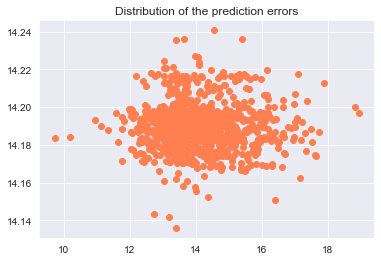

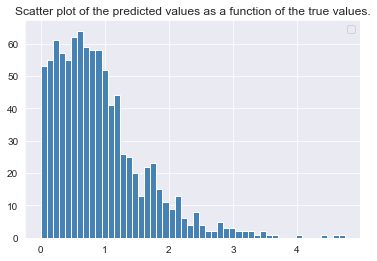

In [66]:
results = evaluate_regression("Random Forest", results, y_test, y_pred_rfr)

In [67]:
# 1) GridSearchCV or RandomizedSearchCV

#### 2) Sequential method : XGBoost

GridSearchCV XGBoost Regressor
Best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Linear Regression,1.18192,1.39693,0.93698,0.81272,-0.04432
0,Ridge manually,1.16766,1.36344,0.92415,0.77115,-0.01928
0,Ridge GridSearchCV,1.15901,1.34331,0.91545,0.77395,-0.00423
0,LASSO manually,1.16064,1.34709,0.91649,0.76878,-0.00705
0,LASSO GridSearchCV,1.15936,1.34411,0.91563,0.77591,-0.00483
0,Elastic Net 1,1.15839,1.34186,0.91528,0.77266,-0.00315
0,Elastic Net 2,1.15934,1.34407,0.91559,0.77595,-0.00480
0,Random Forest,1.15862,1.34241,0.91570,0.77381,-0.00356
0,XGBoost GridSearchCV,1.15847,1.34204,0.90426,0.74554,-0.00328


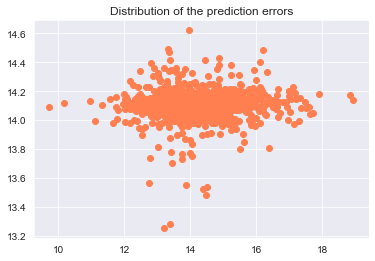

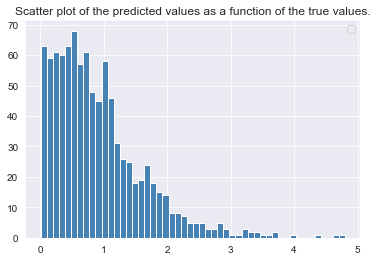

In [68]:
print("GridSearchCV XGBoost Regressor")

from xgboost import XGBRegressor

gsc = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={"learning_rate": (0.05, 0.10, 0.15),
                "max_depth": [ 3, 4, 5, 6, 8],
                "min_child_weight": [ 1, 3, 5, 7],
                "gamma":[ 0.0, 0.1, 0.2],
                "colsample_bytree":[ 0.3, 0.4],},
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#fit the grid search
gsc.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", gsc.best_estimator_)

# best model
best_model = gsc.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_xgbr = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("XGBoost GridSearchCV", results, y_test, y_pred_xgbr)


### III) Evaluation

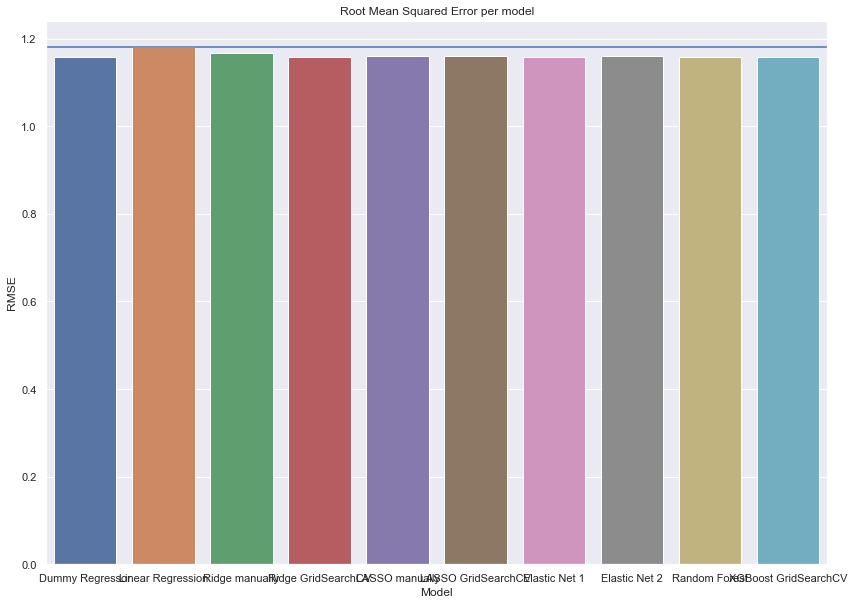

In [69]:
sns.set(rc={'figure.figsize':(14, 10)})
plt.title('Root Mean Squared Error per model')
graph = sns.barplot(x=results["Model"],
            y =results["RMSE"])

baseline_rmse = results["RMSE"][results["Model"] == "Linear Regression"][0] # we take the value inside
#Drawing a horizontal line at point 1.25
graph.axhline(baseline_rmse, color="b")

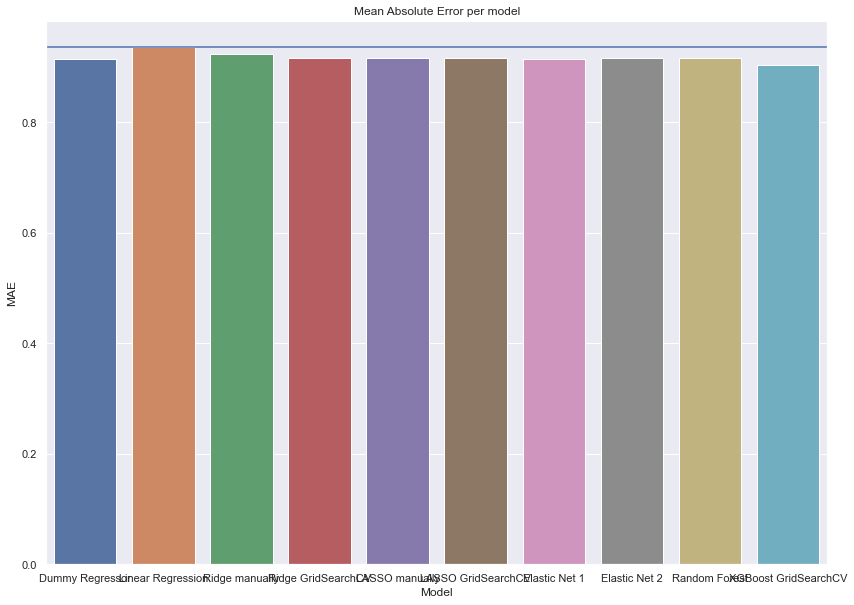

In [70]:
plt.title('Mean Absolute Error per model')
graph = sns.barplot(x=results["Model"],
            y =results["MAE"])

baseline_mae = results["MAE"][results["Model"] == "Linear Regression"][0] # we take the value inside
#Drawing a horizontal line at point 1.25
graph.axhline(baseline_mae, color='b')

#### Intérêt du Energy Star Score
